# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import json
import glob
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
conf.set("spark.executor.memory", "4g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

conf.set("spark.executor.instances", "1")  # кол-во executor'ов
conf.set("spark.executor.cores", "4")  # сколько ядер у каждого

# conf.set("spark.dynamicAllocation.enabled", "true")
# conf.set("spark.shuffle.service.enabled", "true")
# conf.set("spark.dynamicAllocation.initialExecutors", 2)
# conf.set("spark.dynamicAllocation.maxExecutors", 2)

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [4]:
!hdfs dfs -ls data/ml-25m/

Found 9 items
-rw-r--r--   1 root supergroup      10460 2020-02-04 19:46 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2020-02-04 19:46 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2020-02-04 19:46 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2020-02-04 19:46 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2020-02-04 19:46 data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 root supergroup    3038099 2020-02-04 19:46 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2020-02-04 19:46 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2020-02-04 19:46 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2020-02-04 19:46 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [5]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')
LINKS_PATH = os.path.join(DATA_PATH, 'links.csv')
TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')

In [6]:
ratings = sc.textFile(RATINGS_PATH)

In [7]:
ratings.take(5)

['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [8]:
ratings.getNumPartitions()

5

In [9]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [10]:
ratings.count()

25000095

Количество пользователей

In [11]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 76.1 ms, sys: 21.6 ms, total: 97.8 ms
Wall time: 1min 55s


162541

Сохраним датасет в память

In [12]:
ratings = ratings.persist()

In [13]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 60.3 ms, sys: 21.3 ms, total: 81.6 ms
Wall time: 2min 49s


162541

Количество фильмов

In [14]:
ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [15]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [16]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False) \
    .take(10)

[(196959, (5.0, ['196959', 'I Am JFK Jr. (2016)'])),
 (180663, (5.0, ['180663', '"Goodbye'])),
 (147966, (5.0, ['147966', "Tarzan's Fight for Life (1958)"])),
 (131628, (5.0, ['131628', 'Loaded (2014)'])),
 (131922, (5.0, ['131922', 'Private Duty Nurses (1971)'])),
 (188573, (5.0, ['188573', 'Judy (2014)'])),
 (164787, (5.0, ['164787', 'You Cast A Spell On Me (2015)'])),
 (132321, (5.0, ['132321', 'Black Oak Conspiracy (1977)'])),
 (165221, (5.0, ['165221', 'Elf Bowling the Movie (2007)'])),
 (149268, (5.0, ['149268', 'The Pied Piper (1942)']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [17]:
movie_avg_rating \
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [18]:
!hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2020-02-04 19:55 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      58903 2020-02-04 19:55 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112361 2020-02-04 19:55 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131524 2020-02-04 19:55 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114377 2020-02-04 19:55 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133576 2020-02-04 19:55 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117783 2020-02-04 19:55 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     143242 2020-02-04 19:55 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     131984 2020-02-04 19:55 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167729 2020-02-04 19:55 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [19]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [20]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [21]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

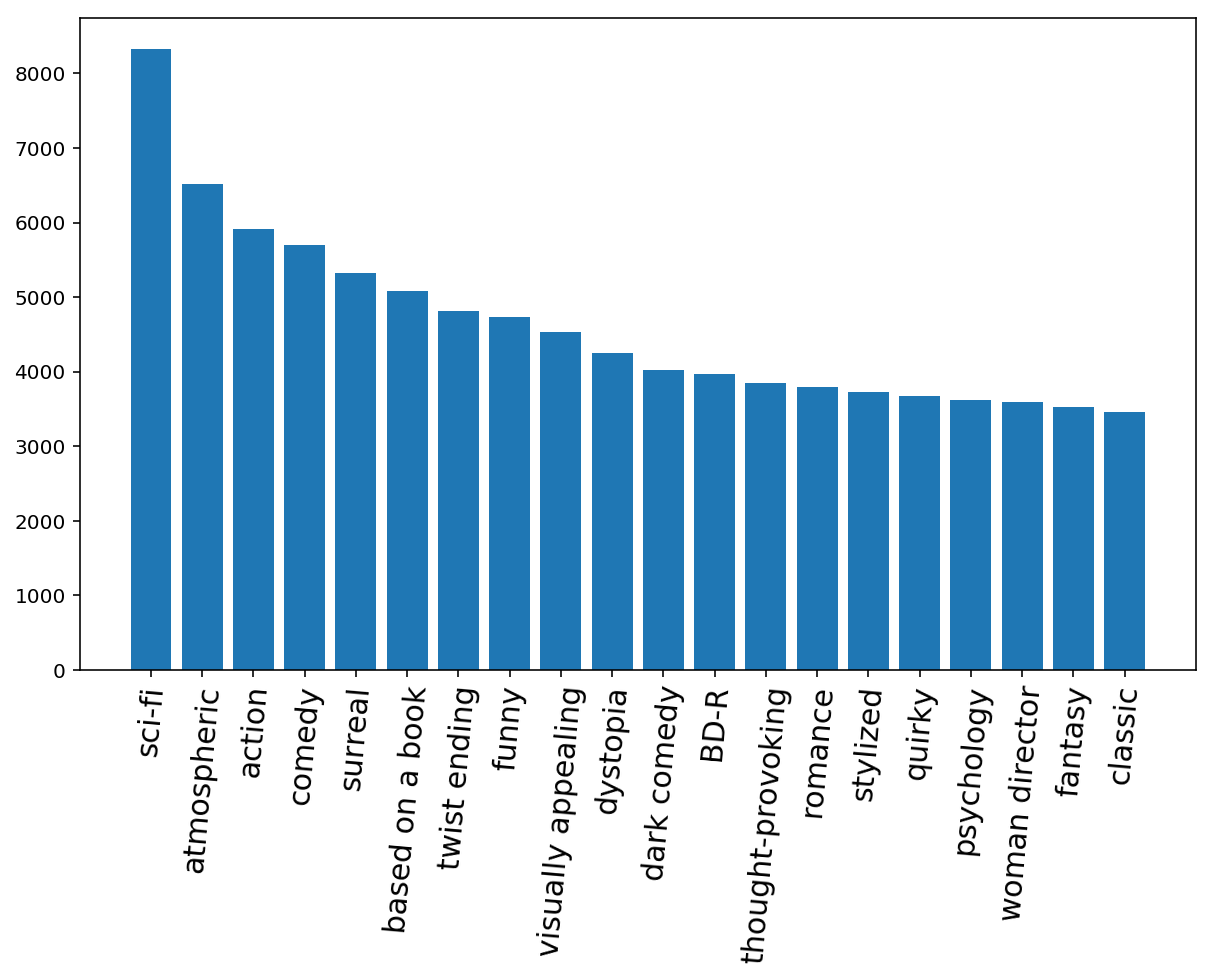

In [22]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [23]:
movie_ratings_count = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda cnt1, cnt2: cnt1 + cnt2) \

movie_ratings_count \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1], ascending=False) \
    .take(10)

[(356, (81491, ['356', 'Forrest Gump (1994)'])),
 (318, (81482, ['318', '"Shawshank Redemption'])),
 (296, (79672, ['296', 'Pulp Fiction (1994)'])),
 (593, (74127, ['593', '"Silence of the Lambs'])),
 (2571, (72674, ['2571', '"Matrix'])),
 (260, (68717, ['260', 'Star Wars: Episode IV - A New Hope (1977)'])),
 (480, (64144, ['480', 'Jurassic Park (1993)'])),
 (527, (60411, ['527', "Schindler's List (1993)"])),
 (110, (59184, ['110', 'Braveheart (1995)'])),
 (2959, (58773, ['2959', 'Fight Club (1999)']))]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [24]:
ratings \
    .filter(lambda r: r.rating == 5.0) \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda cnt1, cnt2: cnt1 + cnt2) \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1], ascending=False) \
    .take(10)

[(318, (39553, ['318', '"Shawshank Redemption'])),
 (296, (32169, ['296', 'Pulp Fiction (1994)'])),
 (356, (25918, ['356', 'Forrest Gump (1994)'])),
 (260, (25804, ['260', 'Star Wars: Episode IV - A New Hope (1977)'])),
 (2571, (25482, ['2571', '"Matrix'])),
 (527, (24853, ['527', "Schindler's List (1993)"])),
 (593, (24801, ['593', '"Silence of the Lambs'])),
 (858, (24418, ['858', '"Godfather'])),
 (50, (21585, ['50', '"Usual Suspects'])),
 (2959, (21486, ['2959', 'Fight Club (1999)']))]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

In [25]:
movies_avg_rating_list = movie_avg_rating \
    .collect()
    
len(movies_avg_rating_list)

59047

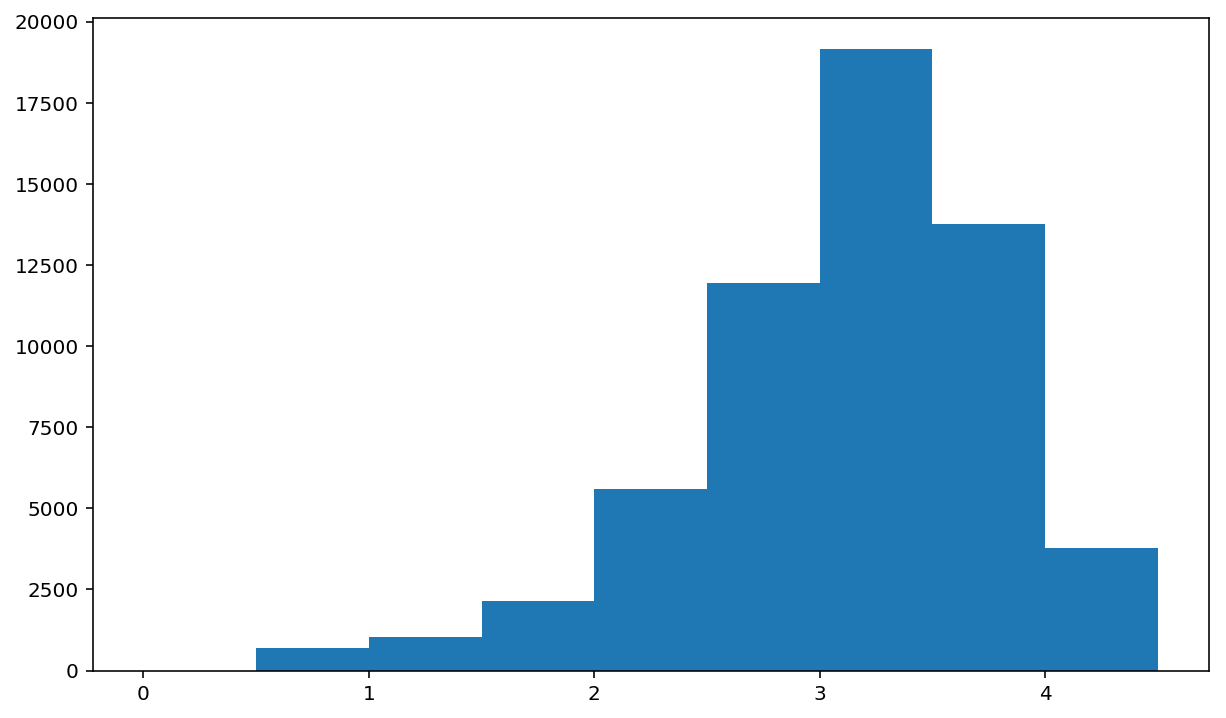

In [26]:
keys, values = zip(*movies_avg_rating_list)

f, ax = plt.subplots(figsize=(10, 6))
bins = np.arange(start=0.0, stop=5.0, step=0.5)
plt.hist(values, bins=bins)
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

In [27]:
movie_ratings_count \
    .count()

movie_ratings_count_sorted = movie_ratings_count \
    .sortBy(lambda key_value: key_value[1], ascending=True) \
    .map(lambda key_value: key_value[1]) \
    .collect()

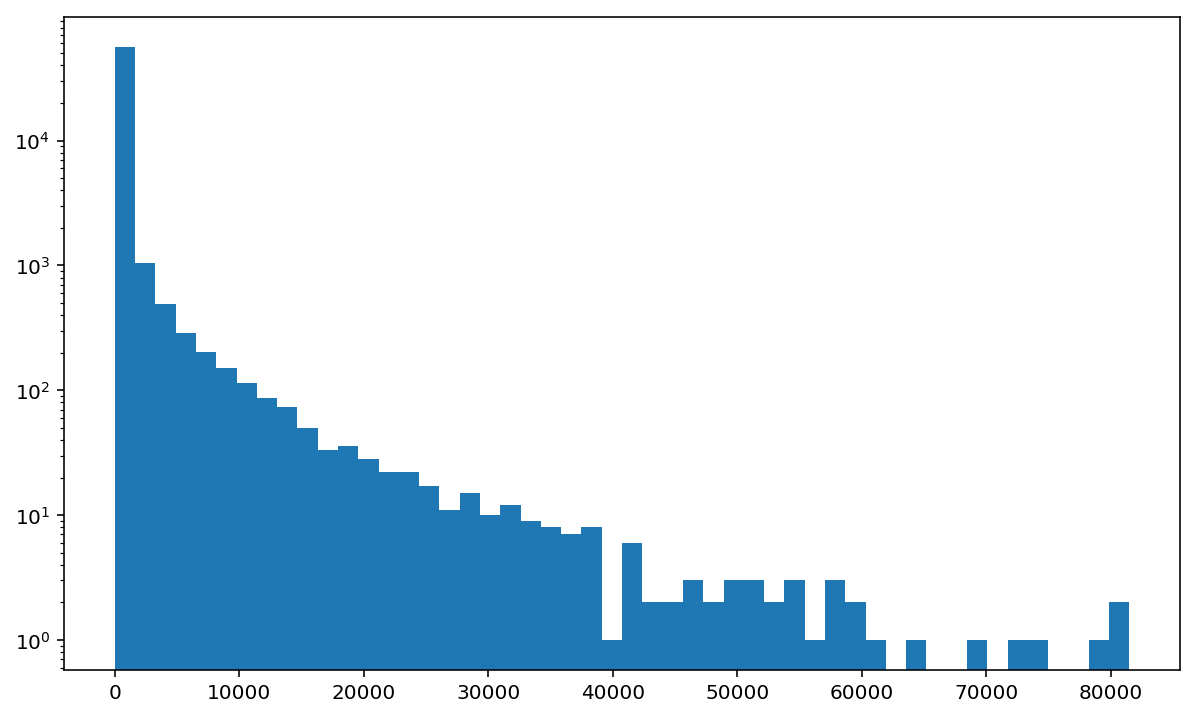

In [28]:
f, ax = plt.subplots(figsize=(10, 6))

n_bins = 50

plt.hist(movie_ratings_count_sorted, n_bins, histtype='bar', log=True)
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [29]:
movie_genre_counts = sc \
    .textFile(MOVIES_PATH) \
    .map(lambda s: (s.split(',', 1)[0], s.rsplit(',', 1)[-1])) \
    .filter(lambda id_genres: id_genres[0].isdigit()) \
    .flatMap(lambda id_genres: id_genres[1].split('|')) \
    .map(lambda genre: (genre, 1)) \
    .reduceByKey(lambda cnt1, cnt2: cnt1 + cnt2) \
    .collect()

print(movie_genre_counts)

[('Sci-Fi', 3595), ('Horror', 5989), ('Drama', 25606), ('Action', 7348), ('Western', 1399), ('Children', 2935), ('Musical', 1054), ('Documentary', 5605), ('Thriller', 8654), ('Fantasy', 2731), ('Romance', 7719), ('IMAX', 195), ('Comedy', 16870), ('(no genres listed)', 5062), ('Adventure', 4145), ('Crime', 5319), ('War', 1874), ('Animation', 2929), ('Mystery', 2925), ('Film-Noir', 353)]


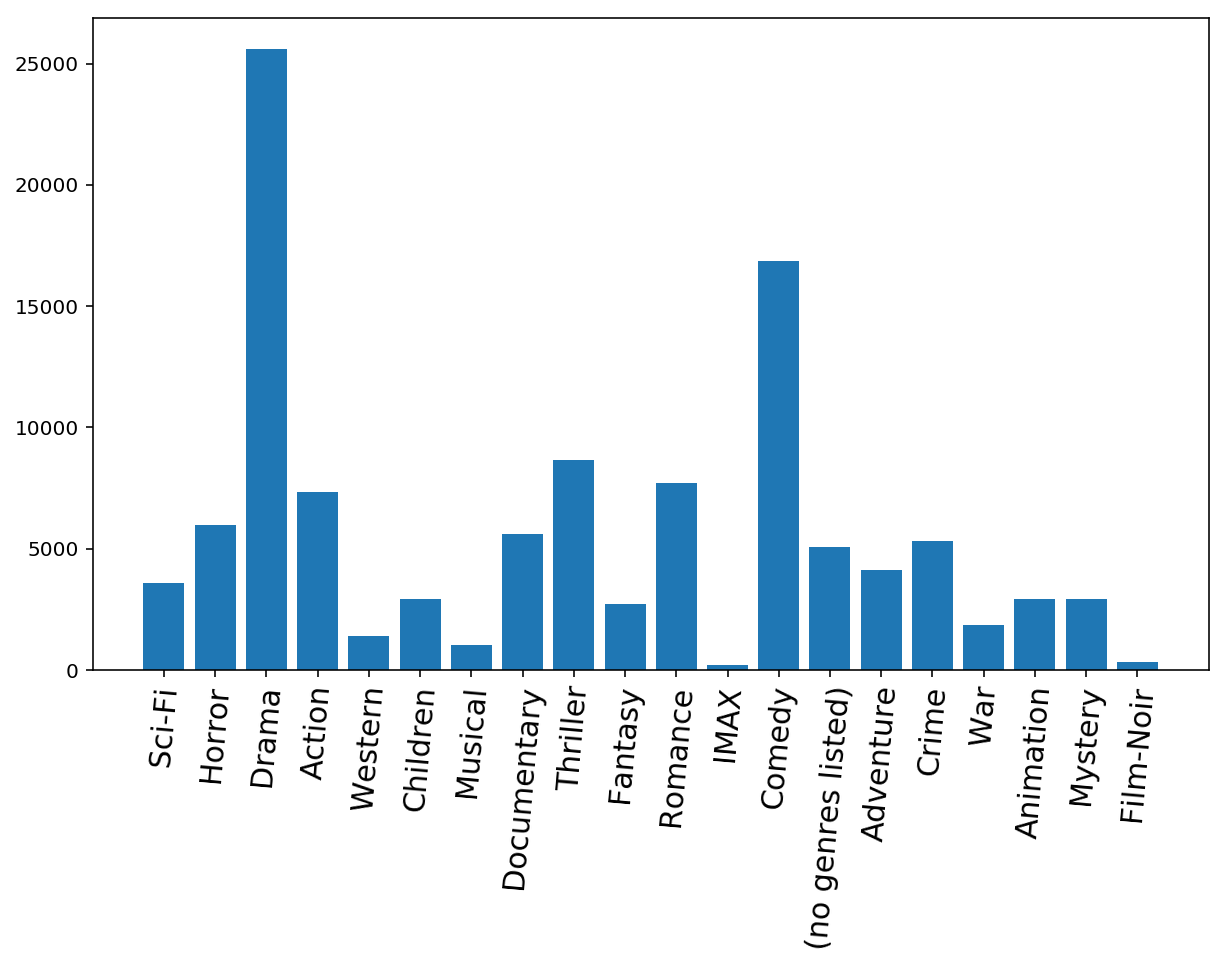

In [30]:
genre_names, genre_counts = zip(*movie_genre_counts[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(genre_names, genre_counts, align="center")
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [31]:
links = sc \
    .textFile(LINKS_PATH) \
    .map(lambda s: s.split(',')) \
    .filter(lambda movie_imd_tmdb: movie_imd_tmdb[2].isdigit()) \
    .keyBy(lambda movie_imd_tmdb: int(movie_imd_tmdb[2]))

In [32]:
tmdb = sc \
    .textFile(TMDB_PATH) \
    .map(lambda s: json.loads(s)) \
    .filter(lambda tmbd_entry: 'id' in tmbd_entry)

tmdb_casts = tmdb \
    .flatMap(lambda tmdb_entry: [(tmdb_entry['id'], cst) for cst in tmdb_entry['casts']['cast']]) \

tmdb_casts_ids = tmdb_casts \
    .map(lambda tmdb_id_cst: (tmdb_id_cst[0], tmdb_id_cst[1]['id']))

# We filter all non-Tom Hanks movies, join with links and leave only the movie_ids to join with movies
tom_hanks_movies = tmdb_casts_ids \
    .filter(lambda tmdb_cast_id: tmdb_cast_id[1] == 31) \
    .keyBy(lambda tmdb_cast_id: tmdb_cast_id[0]) \
    .join(links) \
    .map(lambda key_value: key_value[1][1][0]) \
    .keyBy(lambda movie_id: int(movie_id)) \
    .join(movies) \
    .collect()

print(len(tom_hanks_movies), "movies")
for movie in tom_hanks_movies:
    print(movie)

76 movies
(539, ('539', ['539', 'Sleepless in Seattle (1993)']))
(581, ('581', ['581', '"Celluloid Closet']))
(117684, ('117684', ['117684', 'Elvis Has Left the Building (2004)']))
(2072, ('2072', ['2072', '"\'burbs']))
(2100, ('2100', ['2100', 'Splash (1984)']))
(183043, ('183043', ['183043', 'Every Time We Say Goodbye (1986)']))
(3255, ('3255', ['3255', '"League of Their Own']))
(105504, ('105504', ['105504', 'Captain Phillips (2013)']))
(106022, ('106022', ['106022', 'Toy Story of Terror (2013)']))
(73472, ('73472', ['73472', 'Shooting War (2000)']))
(107352, ('107352', ['107352', 'Killing Lincoln (2013)']))
(1, ('1', ['1', 'Toy Story (1995)']))
(132070, ('132070', ['132070', 'And the Oscar Goes To... (2014)']))
(3130, ('3130', ['3130', 'Bonfire of the Vanities (1990)']))
(4012, ('4012', ['4012', 'Punchline (1988)']))
(4677, ('4677', ['4677', 'Turner & Hooch (1989)']))
(54272, ('54272', ['54272', '"Simpsons Movie']))
(87522, ('87522', ['87522', 'Larry Crowne (2011)']))
(195063, ('19

In [33]:
tmdb_casts \
    .map(lambda tmdb_id_cast: (tmdb_id_cast[1]['id'], (tmdb_id_cast[1]['name'], 1))) \
    .reduceByKey(lambda info1, info2: (info1[0], info1[1] + info2[1])) \
    .sortBy(lambda cast_id_info: cast_id_info[1][1], ascending=False) \
    .take(10)

[(121323, ('Bess Flowers', 380)),
 (15831, ('Frank Welker', 184)),
 (113, ('Christopher Lee', 175)),
 (78077, ('Clarence Nash', 158)),
 (30530, ('Irving Bacon', 152)),
 (8516, ('John Carradine', 146)),
 (4165, ('John Wayne', 142)),
 (33923, ('Mel Blanc', 140)),
 (2231, ('Samuel L. Jackson', 134)),
 (21315, ('Eric Roberts', 130))]

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [34]:
links = sc \
    .textFile(LINKS_PATH) \
    .map(lambda s: s.split(',')) \
    .filter(lambda movie_imd_tmdb: movie_imd_tmdb[2].isdigit()) \
    .keyBy(lambda movie_imd_tmdb: int(movie_imd_tmdb[0]))

tmdb_id_genres = sc \
    .textFile(MOVIES_PATH) \
    .map(lambda s: (s.split(',', 1)[0], s.rsplit(',', 1)[-1])) \
    .filter(lambda id_genres: id_genres[0].isdigit()) \
    .flatMap(lambda id_genres: [(id_genres[0], genre) for genre in id_genres[1].split('|')]) \
    .keyBy(lambda id_genre: int(id_genre[0])) \
    .join(links) \
    .map(lambda movie_id_info: (int(movie_id_info[1][1][-1]), movie_id_info[1][0][1]))


tmdb_id_genres.take(10)

[(150056, 'Comedy'),
 (98536, 'Drama'),
 (31357, 'Comedy'),
 (31357, 'Drama'),
 (31357, 'Romance'),
 (45325, 'Adventure'),
 (45325, 'Children'),
 (285684, 'Comedy'),
 (285684, 'War'),
 (12110, 'Comedy')]

In [35]:
tmdb_years = tmdb \
    .filter(lambda tmdb_entry: tmdb_entry.get('release_date')) \
    .map(lambda tmdb_entry: (int(tmdb_entry['id']), int(tmdb_entry['release_date'].split('-')[0])))

genre_year_cnts = tmdb_id_genres \
    .join(tmdb_years) \
    .map(lambda tmdb_genre_year: ((tmdb_genre_year[1][0], tmdb_genre_year[1][1]), 1)) \
    .reduceByKey(lambda cnt1, cnt2: cnt1 + cnt2) \
    .collect()

genres = {}
years = set()
for (genre, year), cnt in genre_year_cnts:
    if genre == '(no genres listed)':
        continue
    if genre not in genres:
        genres[genre] = {}
    genres[genre][year] = genres[genre].get(year, 0) + cnt
    years.add(year)

# Build a matrix with each row representing the number of genre appearances
x = list(sorted(list(years)))
y = list(genres.keys())
A = np.zeros((len(y), len(x)))
for i, genre in enumerate(y):
    genre_dict = genres[genre]
    for j, year in enumerate(x):
        A[i, j] = genre_dict.get(year, 0)

# Normalize, so each column is a probability distribution
A = A / A.sum(axis=0)
print(A.shape)

(19, 134)


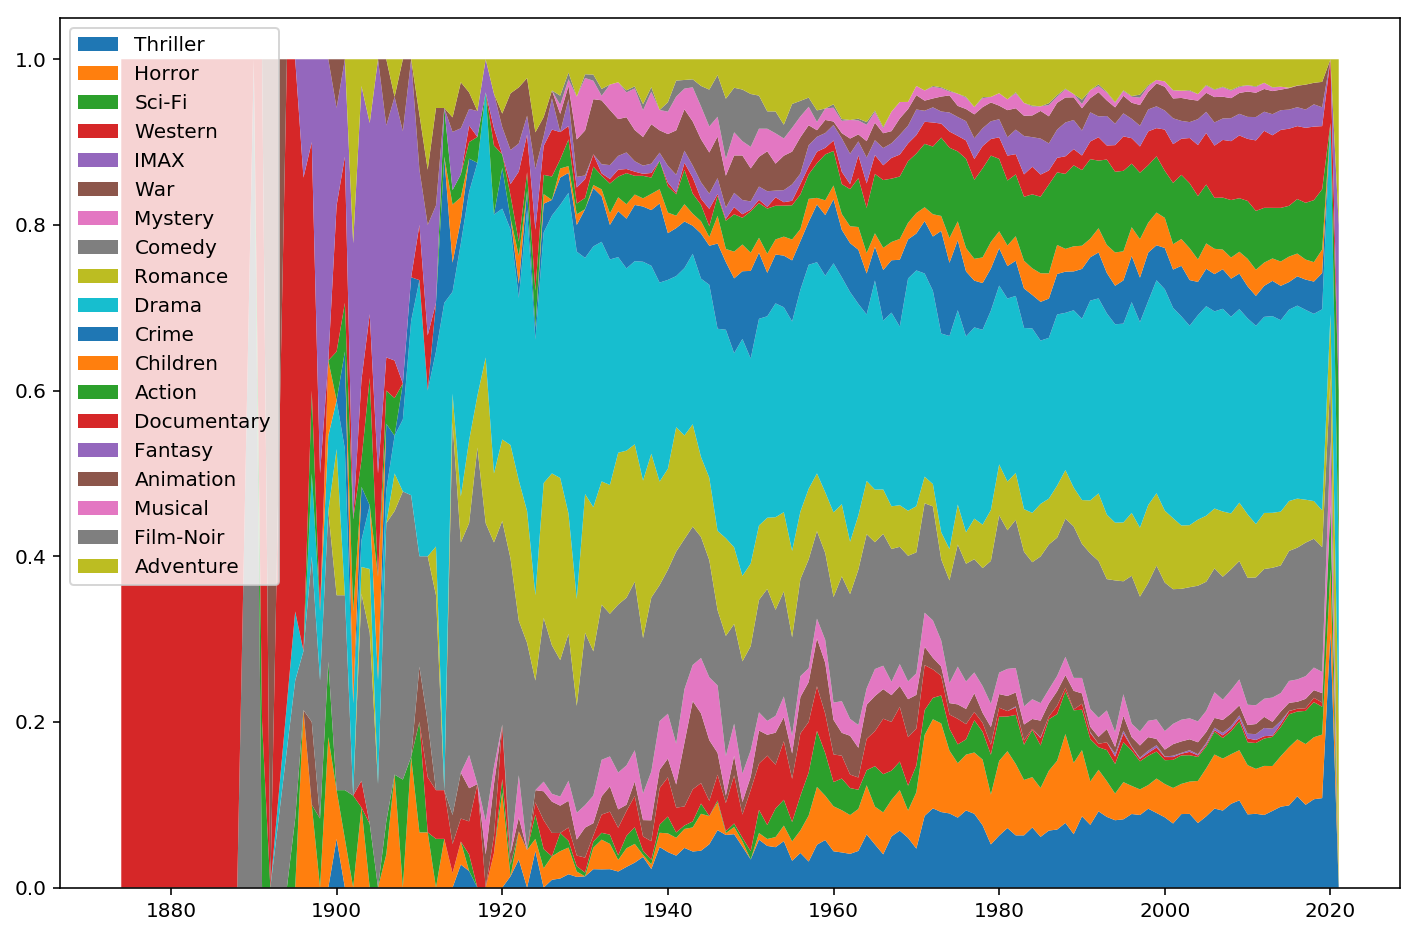

In [36]:
f, ax = plt.subplots(figsize=(12, 8))
plt.stackplot(x, A, labels=y)
plt.legend(loc='upper left')
plt.show()

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [37]:
tmdb_revenue_budget = tmdb \
    .filter(lambda tmdb_entry: tmdb_entry.get('revenue')) \
    .filter(lambda tmdb_entry: tmdb_entry.get('budget')) \
    .map(lambda tmdb_entry: (int(tmdb_entry['id']), (int(tmdb_entry['revenue']), int(tmdb_entry['budget']))))

# We can factor out count, since (total_revenue / count) / (total_budget / count) = 
# = total_revenue / total_budget
genre_name_rois = tmdb_id_genres \
    .filter(lambda tmdb_id_genre: tmdb_id_genre[1] != '(no genres listed)') \
    .join(tmdb_revenue_budget) \
    .map(lambda key_value: (key_value[1][0], (key_value[1][1][0], key_value[1][1][1], 1))) \
    .reduceByKey(lambda info1, info2: (info1[0]+info2[0], info1[1]+info2[1], info1[2]+info2[2])) \
    .map(lambda genre_info: (genre_info[0], genre_info[1][0] / genre_info[1][1])) \
    .collect()

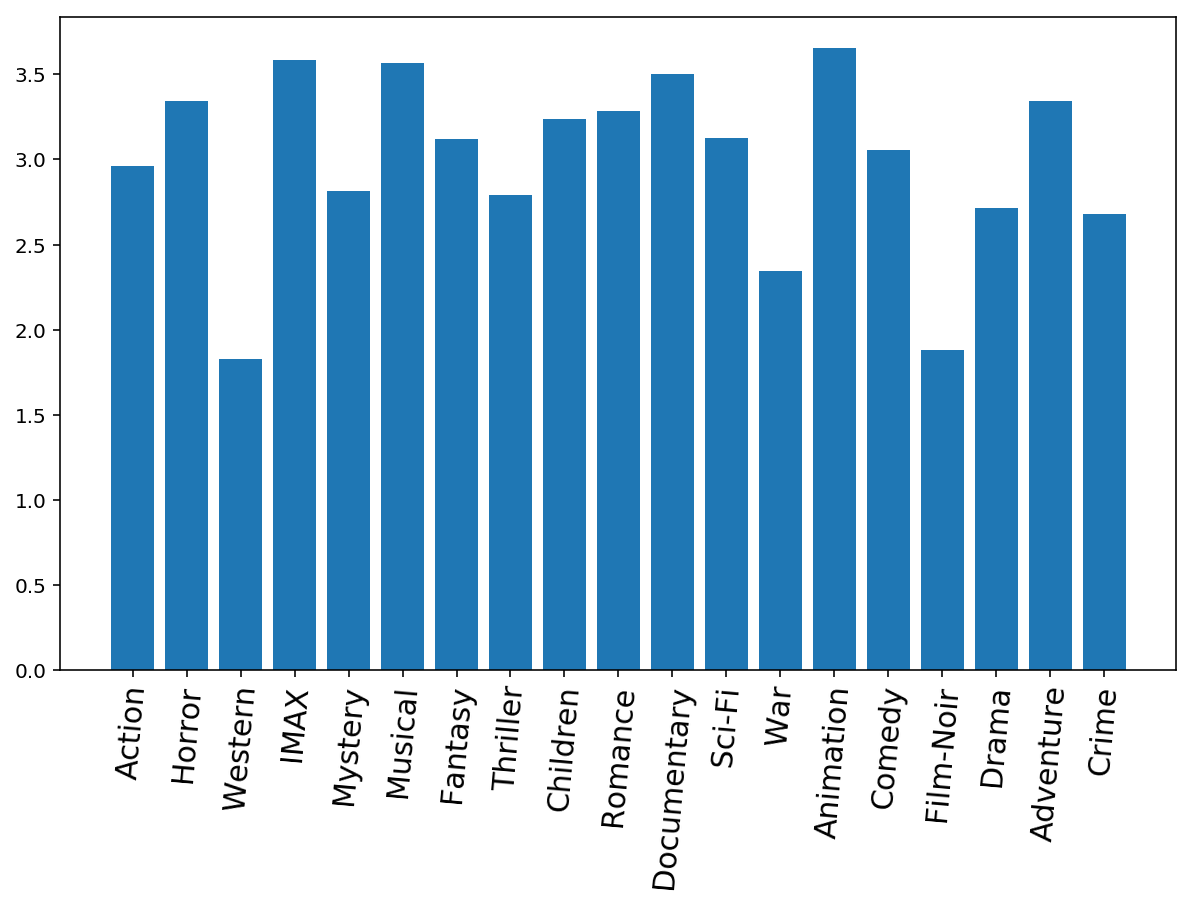

In [38]:
genre_names, genre_rois = zip(*genre_name_rois)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(genre_names, genre_rois, align="center")
plt.show()